# Poisson likelihood calculator

Given $M$ components, each with an estimated rate $\vec{\beta}$ determined by a normal distribution with uncertainty $\vec{\sigma}$, calculate the confidence itervals and perform a hypothesis tests for each parameter $b$.

Nominally each event corresponds to a set of observables $\vec{x}$ of $N$ measurements, for any given measurement, the probability for that particular measurement to come from a particular components is given by

$$ P_i(\vec{x}) \tag{1}$$

The prior probability is then formed through a combination of these components such that the total probability is 

$$ \mathbf{P} = \sum_i^M P_i(\vec{x}) \tag{2}$$

The likelihood for a full data set of $N$ measurements is the product of each event total probability

$$
\mathcal{L}(\vec{x}) = 
\prod_j^N \left( \sum_i^M b_iP_i(\vec{x}) \right) / \sum_i^Mb_i 
\tag{3}
$$

We can extend the likelihood by proclaiming that each components as well as the sum of components are simply a stochastic process, produces the extended likelihood:

$$
\mathcal{L}(\vec{x}) = 
\frac{\text{e}^{-\sum_i^Mb_i}}{N!} \prod_j^N \left( \sum_i^M b_iP_i(\vec{x}) \right) 
\tag{4}
$$

Finally, we can claim that we have _a priori_ knowledge of the parameters, whether it be through side-band analysis or external constraints, by including those constraints via some prior probability. Given no specific knowledge of the shape of that prior, we will consider the information we receive on the variables to be normally distributed and multiply the likelihood by those constraints

$$
\mathcal{L}(\vec{x}) = 
\frac{\text{e}^{-\sum_i^Mb_i}}{N!} 
\prod_j^N \left( \sum_i^M b_iP_i(\vec{x}) \right) 
\frac{1}{\sqrt{2\pi \sigma_i^2}}
\text{exp}\left({\frac{-(\beta_i-b_i)^2}{2\sigma_i^2}}\right)
\tag{5}
$$

A few definitions to simplify things:
$$ \lambda := \sum_i^Mb_i \tag{6}$$

Then then our objective function $\mathcal{O} = -\text{Ln}\mathcal{L}$

$$
\mathcal{O} = \lambda + \text{Ln}N! 
-\sum_j^N\text{Ln}\left( \sum_i^M b_iP_i(\vec{x}) \right) 
+ \sum_i^M \left( \frac{(\beta_i-b_i)^2}{2\sigma_i^2} 
    + \text{Ln}\sqrt{2\pi \sigma_i} \right)
\tag{7}
$$

Finally, for a counting analysis we assume that an optimal set of cuts has been applied which optimizes the sensitivity to a particular parameter, which simplifies the likelihood such that

$$ P_i(\vec{x}) := 1 \tag{8}$$

Also, because the shape of the likelihood space is independent of constant parameters, we can drop the $\text{Ln}\sqrt{2\pi \sigma_i}$ terms. We could also remove the $\text{Ln}N!$ term as well, but for numerical stability we will keep it around, but use Sterling's approximation: $\text{Ln}N! \approx N\text{Ln}N - N$. The remaining objective function we will thus use is:

$$
\mathcal{O} = \lambda - N\text{Ln}\lambda + N\text{Ln}N - N 
    + \sum_i^M \left( \frac{(\beta_i-b_i)^2}{2\sigma_i^2} \right)
\tag{9}
$$

_Note: If the different values of $\beta$ differ by orders of magnitude, it might be worth forming an affine invariant form of the likelihood, otherwise the $\text{Ln}\sqrt{2\pi \sigma_i}$ term should not matter_

[Profile Likelihood](https://www.stat.tamu.edu/~suhasini/teaching613/chapter3.pdf)

In [1]:
include("./src/WatchFish.jl")
using .WatchFish

### Model Building
Three structures are used to build, test, and fit models. These are the `Model`, `Component`, and `Result`--all of which are mutable.

We begin by initializing a default `Model` and one-by-one use `add_component!` to modify the `Model`.

The intention is to provide multiple ways to evaluate the uncertainties, the default here is to compute the profile likelihood.

In [22]:
m = CountingExperiment()

add_component!(m, "Signal", 20.0)
add_component!(m, "Bkg 1", 30.0; σ=0.1)
add_component!(m, "Bkg 2", 40.0; σ=45.0)
add_component!(m, "Bkg 3", 12.0; σ=12.0)

set_counts!(m, 100)

results = minimize!(m)

compute_profiled_uncertainties!(results; σ=1)
pretty_results(results)

,Name,Fit,Interval_Low,Interval_High
,String,Float64,Float64,Float64
1,Bkg 1,30.0,30.0,30.0
2,Bkg 2,40.0,1.0,67.0
3,Bkg 3,12.0015,1.00146,23.0015
4,Signal,17.9979,-23.0021,58.9979


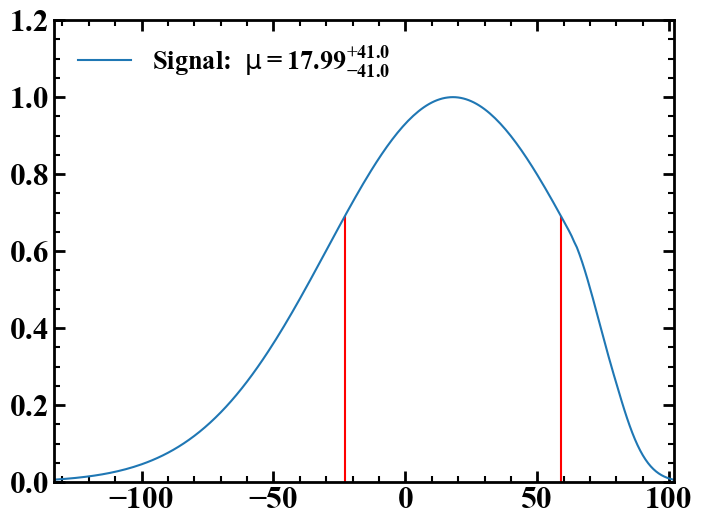

(y[x .>= low])[1] = 0.6901178106433539


In [24]:
using PyPlot
plt.style.use("fish.mplstyle")

#hs = x -> x >= 0 ? 1 : 0
#profile!("Signal", results; prior=hs)
#uncertainty!("Signal", results )

interval_plot(results, "Signal")

#plt.xlim(-10, 100)
plt.savefig("profile.svg")
plt.show()

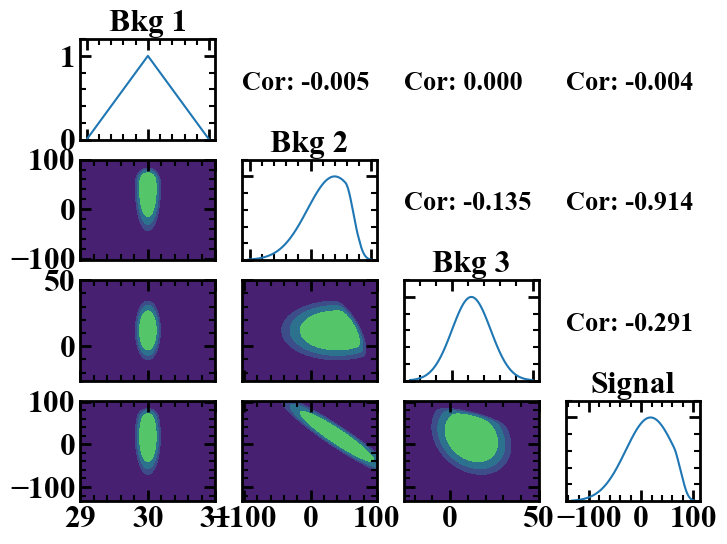

In [25]:
using PyPlot

correlation_plots(results)

plt.savefig("Correlations.svg")
plt.show()

In [5]:
# Correlation Matrix -- Derive from correlation_plots, store in results

In [5]:
# Generate fake experiments; two set => Positive, Negative

## Is this the correct way to express everything. One model per time t (say day)

days = collect(1:5:1000) # 1 to 100 days
days = exp10.(range(0,stop=4,length=100))
hs = x -> x >= 0 ? 1 : 0

results_set = []
for d in days
    m = CountingExperiment()

    add_component!(m, "Signal", 2.0*d)
    add_component!(m, "Bkg 1", 3.0*d; σ=0.2*d)

    set_counts!(m, 4.0 * d)

    results = minimize!(m)
    profile!("Signal", results; prior=hs, step=0.1, stop=20)
    uncertainty!("Signal", results, σ=1)   
    push!(results_set, results)
end

# Results stored in a DataFrame.jl
#compute_profiled_uncertainties!(results; σ=1)
#pretty_results(results)

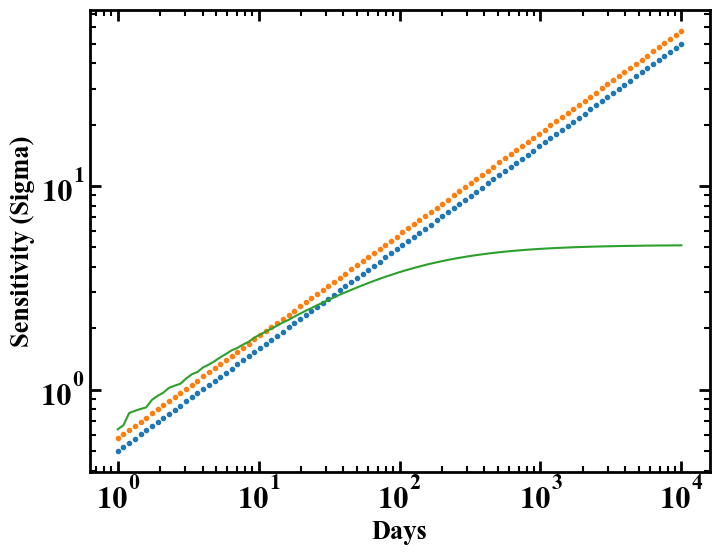

sensitivity("Signal", results_set[20]) = 0.8649683135820136


In [27]:
using SpecialFunctions
sens = []

function sensitivity(name, results;
    mode="FC", prior=nothing)

    comp = getparam(results.model, name)
    x, y = comp.likelihood_x, comp.likelihood_y
    if prior != nothing
        y = y .* prior.(x)
    end
    xselect = (x .>= 0)
    x = x[xselect]
    y = y[xselect]
    y = y / sum(y)
    cumulative = cumsum(y)
    if mode == "FC"
        cy = sortperm(y; rev=true)
        cum_y = cumsum(y[cy])
        cum_x = x[cy]
        # Need to find where it first crosses zero
        first_min = cum_y[ cum_x .== x[1] ]
    end
    return minimum([first_min[1], 1])
end

@show sensitivity("Signal", results_set[20])

for rs in results_set
    push!(sens, erfinv( sensitivity("Signal", rs))*2^0.5 )
end


plt.plot(days, 1/sqrt(4)*sqrt.(days),".")
plt.plot(days, 1/sqrt(3)*sqrt.(days),".")
plt.plot(days, sens)
plt.ylabel("Sensitivity (Sigma)")
plt.xlabel("Days")
plt.yscale("log")
plt.xscale("log")
plt.savefig("sensitivity.svg")
plt.show()
#interval_plot(results_set[20], "Signal")
#@show days[ lb .>= 0 ][1]
#plot(days, lb)

In [8]:
# Cowen Plot

In [9]:
# ROC curve

In [10]:
# Confusion Matrix

In [11]:
# Documentation

In [12]:
# Refactor code into sub-files, project.toml, mybinder, etc ...

In [13]:
# Time dependent systematic (maybe)

In [14]:
### Spectral BELOW, Need to fix

In [17]:
# shape, 2 bkg + signal
using Random
using DataFrames

m = CustomModel()


add_dataset(:data, DataFrame( energy=( randn(1000).*3.5 .+ 20.0 )) )
# Todo, add this as return to add_dataset, and put in macro
data = WatchFish.data

@show size(data, 1)
@addfunction gausfit(μ,σ) = begin
    sum( -log.( exp.(-( data.energy.-μ).^2/2/σ^2)/sqrt(2π*σ^2) ) )
end

signal = Parameter("signal"; init=15.0)
background = Parameter("background"; init=2.5)
norm = Parameter("N"; init=10.0)
observation_count = Parameter("obs"; init=1000.0, constant=true )

add_parameters!(m, [signal, background, norm, observation_count])

extend = NLogPDF("logpoisson", observation_count, norm)
pdf = NLogPDF("gausfit", signal, background)
add_nlogpdfs!(m, [pdf, extend])

#nll.objective([20.0, 3.5])
#_, bfit, _ = minimize!(m)
results = minimize!(m)

## What is bfit in this case?
bfit = results.min_parameters
compute_profiled_uncertainties!(results; σ=1)
pretty_results(results)

size(data, 1) = 1000


,Name,Fit,Interval_Low,Interval_High
,String,Float64,Float64,Float64
1,signal,19.9666,19.9666,19.9666
2,background,3.35555,3.35555,3.35555
3,N,1000.0,970.0,1031.0


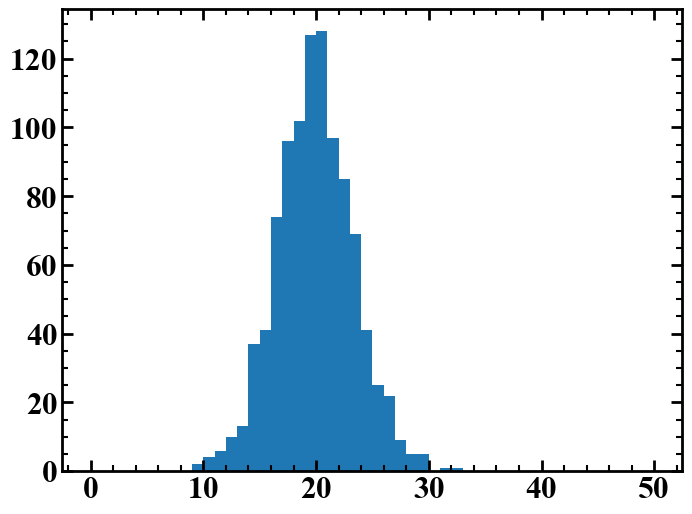

bfit = [19.927170192680748, 3.395177273824146, 999.9999704280708]


In [7]:
using PyPlot

@show bfit

x = collect(0:1:50)
plt.hist(data.energy, bins=x)
plt.show()

In [21]:
## Lets fit the normalization, given we know the shapes
df1 = DataFrame(energy=( randn(100).*2.0 .+ 20.0 ) )
append!(df1, DataFrame(energy=( randn(200).*5.0 .+ 23.0 ) ))
append!(df1, DataFrame(energy=( randn(50).*1.0 .+ 18.0 ) ))

add_dataset(:tri, df1 )
tri = WatchFish.tri

cow = CustomModel()

@addfunction shape(μ, σ) = @. exp(-(tri.energy-μ)^2/2/σ^2)/sqrt(2π*σ^2)
#@addfunction shape(μ, σ) = @. tri.energy*0 + 1

## Free parameters
s  = Parameter("signal"; init=1.0)
b1 = Parameter("bkg1"; init=1.0)
b2 = Parameter("bkg2"; init=1.0)
## Data counts
observation_count = Parameter("obs"; init=Float64( size(tri,1) ), constant=true )
## Known Means
sm = Parameter("Signal Mean"; init=20.0, constant=true)
bm1 = Parameter("Bkg1 Mean"; init=23.0, constant=true)
bm2 = Parameter("Bkg2 Mean"; init=18.0, constant=true)
## Known Sigma
ss = Parameter("Signal Sig"; init=2.0, constant=true)
bs1 = Parameter("Bkg1 Sig"; init=5.0, constant=true)
bs2 = Parameter("Bkg2 Sig"; init=1.0, constant=true)


## Build the PDF functions
@addfunction spectralpdf(b1, b2, b3, m1, m2, m3, s1, s2, s3) = begin
    -sum(log.( b1*shape(m1, s1) .+ b2*shape(m2, s2) .+ b3*shape(m3, s3) ))
end
@addfunction logextend(n, x...) = begin
    λ = sum([x...])
    λ + n*log(n) - n
end
## Construct NLL
ob1 = NLogPDF("spectralpdf", s, b1, b2, sm, bm1, bm2, ss, bs1, bs2)
ob2 = NLogPDF("logextend", observation_count, s, b1, b2)
#nll = NLogLikelihood([ob1, ob2])

add_parameters!(cow, [s, b1, b2, observation_count, sm, bm1, bm2, ss, bs1, bs2])
add_nlogpdfs!(cow, [ob1, ob2])
cow_results = minimize!(cow)
@show cow_results

compute_profiled_uncertainties!(cow_results; σ=1)
pretty_results(cow_results)

Fit converged after 255 iterations
Best fit at: -LnL = 994.5432254829527
Values of [89.4081701367028, 196.48772037730484, 64.14186815680105]
cow_results = 


,Name,Fit,Interval_Low,Interval_High
,String,Float64,Float64,Float64
1,signal,89.4082,69.4082,109.408
2,bkg1,196.488,178.488,215.488
3,bkg2,64.1419,51.1419,77.1419


In [ ]:
## NICE; Lets hold and come back